Instructions for updating:
Use `tf.global_variables_initializer` instead.
------------------------------------------------------------------
learning_start
step: 0 ----- cost: 0.396336
step: 1000 ----- cost: 0.00061612
step: 2000 ----- cost: 0.00040925
learning_end
------------------------------------------------------------------
testing....
Error_is  1.48185 % 


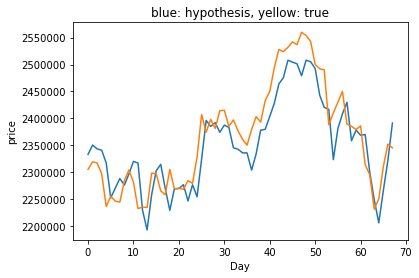

In [1]:
# ---------------------------------------------------------------------------------------------- 
# the purpose of this code is to predict stock price of samsung electronics. 
# this code is inappropriate for predicting stock price.....
# when i write this code, i refered to the youtube lecture which link 
# "https://www.youtube.com/watch?v=odMGK7pwTqY&index=47&list=PLlMkM4tgfjnLSOjrEJN31gZATbcj_MpUm"
# I am not so good at English. So please be good to understand my awkward English. 
# ---------------------------------------------------------------------------------------------- 

# import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# preprocessing dataset
with tf.name_scope("Preprocessing") as scope:
    
    # load data file
    data = np.loadtxt("C:\\Users\\minguk\\Documents\\tensorflow\\stock_data_set.csv", delimiter =',', dtype =np.float32)

    # make x,y data sets
    data_x = data
    data_y = data[:,[1]]
    
    # minmaxscaler
    scaler = MinMaxScaler()
    data_x = scaler.fit_transform(data_x)
    data_y = scaler.fit_transform(data_y)
    
    # define paramata
    input_size = 6
    sequence_length = 21 # i will use 21 days average price line.
    output_size = 1
    hidden_size = 14 # i select arbitrary number.
    batch_size = len(data_y)- sequence_length # 255
    logs_path = "./graph/RNN"
    
    # make batch holders
    batch_xs = []
    batch_ys = []

    # make batches
    for a in range(batch_size):
        arbit_x = data_x[a:a+sequence_length,:]
        arbit_y = data_y[a+sequence_length]
        batch_xs.append(arbit_x)
        batch_ys.append(arbit_y)

    # make train, test datasets
    train_size = int(batch_size*0.7)
    test_size = batch_size - train_size
    train_xs,train_ys = np.array(batch_xs[:train_size], np.float32), np.array(batch_ys[:train_size])
    test_xs, test_ys = np.array(batch_xs[train_size:], np.float32), np.array(batch_ys[train_size:])

X = tf.placeholder(tf.float32, shape = [None,sequence_length,input_size], name = "X")
Y = tf.placeholder(tf.float32, shape = [None,output_size], name = "Y")

# RNN layer
with tf.name_scope("RNN_cell") as scope:
    cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple="True",activation = tf.nn.relu)
    outputs,_state = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32)

# fully connected layer(use regression and xavier initializer)
with tf.name_scope("fully_connected") as scope:
    outputs = outputs[:,-1]
    weight = tf.get_variable("weight", shape = [hidden_size,output_size], 
                             initializer = tf.contrib.layers.xavier_initializer())
    bias = tf.get_variable("Bias", shape =[output_size], initializer = tf.contrib.layers.xavier_initializer())
    hypothesis = tf.matmul(outputs,weight)+ bias

# make cost function and optimize cost by using AdamOptimizer    
with tf.name_scope("cost_optimizer") as scope:
    cost = tf.reduce_mean(tf.square(hypothesis-Y))
    optimizer = tf.train.AdamOptimizer(learning_rate =0.003).minimize(cost) # use AdamOptmizer  

# define Error
Error = tf.reduce_mean((Y-hypothesis)/Y)*100

# tensorboard code
cost_graph = tf.summary.scalar("cost",cost)
Error_graph = tf.summary.scalar("Error", Error)
summary = tf.summary.merge_all()

# initialize_all_variables
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# tensorboard code 
writer = tf.summary.FileWriter(logs_path)
writer.add_graph(sess.graph)

# training
print("------------------------------------------------------------------")
print("learning_start")
for b in range(3000):
    cost_val,s,_ = sess.run([cost,summary,optimizer], feed_dict ={X:train_xs, Y:train_ys})
    writer.add_summary(s,global_step = b)
    if b %1000 ==0:
        print("step:",b,"-----","cost:",cost_val)
print("learning_end")
print("------------------------------------------------------------------")
print("testing....")

# calculate Error and predict price information
Error_val, hypothesis_val = sess.run([Error,hypothesis], feed_dict = {X:test_xs, Y:test_ys})
hypothesis_val = scaler.inverse_transform(hypothesis_val)
test_ys = scaler.inverse_transform(test_ys)
print("Error_is ",Error_val,"% ")

# make graph
plt.plot(hypothesis_val)
plt.plot(test_ys)
plt.xlabel("Day")
plt.ylabel("price")
plt.title("blue: hypothesis, yellow: true")
plt.show()
